In [0]:
filepath = 'brown_tokenized.txt'

In [0]:
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
    
def load(filepath, window_size, vocab_size=None):

    words = []
    with open(filepath, 'r', encoding='utf8') as file:
        words = word_tokenize(file.readline())    

    x_train, y_train = [], []
    for i in range(len(words) - window_size + 1):
        x_train.append(words[i: i + window_size - 1])
        y_train.append(words[i +  window_size - 1])
    
    vocab = [word[0] for word in Counter(words).most_common(vocab_size)]
    word2id = { vocab[i]: i for i in range(len(vocab)) }
    
    return np.array(x_train), np.array(y_train)[:,None], np.array(vocab), word2id

def load_zh(filepath, window_size, vocab_size=None):

    words = []
    with open(filepath, 'r', encoding='utf8') as file:
        for line in file:
            words += word_tokenize(line.strip())
        

    x_train, y_train = [], []
    for i in range(len(words) - window_size + 1):
        x_train.append(words[i: i + window_size - 1])
        y_train.append(words[i +  window_size - 1])
    
    vocab = [word[0] for word in Counter(words).most_common(vocab_size)]
    word2id = { vocab[i]: i for i in range(len(vocab)) }
    
    return np.array(x_train), np.array(y_train)[:,None], np.array(vocab), word2id
            
def convert_to_id(x_train, y_train, vocab):
    
    word_to_id = {}
    for i, vocab in enumerate(vocab):
        word_to_id[vocab] = i
        
    for i in range(len(x_train)):
        x_train[i] = [word_to_id[word] for word in x_train[i]]
        y_train[i] = word_to_id[y_train[i][0]]
        
    return x_train.astype(int), y_train.astype(int)


def next_batch(x_train, y_train, batch_size):
    
    num_batch = len(x_train) // batch_size + 1
    for n in range(num_batch):        
        offset = n * batch_size
        x_batch = x_train[offset: offset + batch_size]
        y_batch = y_train[offset: offset + batch_size]
        
        yield x_batch, y_batch
        
# def convert_to_word(x_train, y_train, id_to_word):
#     for i in range(len(x_train)):
#         print(x_train[i])
#         x_train[i] = id_to_word[x_train[i]]
#         y_train[i] = id_to_word[y_train[i]]
#     return x_train, y_train

In [0]:
# hyperparameter
# TODO: change to number of batches 
batch_size = 30
# TODO: edit to be less hacky
window_size = 6
vocab_size = None
hidden_size = 50
emb_dim = 60
learning_rate = 0.8
epoch_size = 20

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
# TODO: split into train, valid, test

In [0]:
x_raw, y_raw, vocab, word2id = load_zh(filepath, window_size, vocab_size)
vocab_size = len(vocab)
print('vocab_size: {}'.format(vocab_size))

vocab_size: 60500


In [0]:
vocab

array(['the', ',', '.', ..., 'Came', 'Williams-', '.m'], dtype='<U43')

In [0]:
# integer representations of vocab
x_train, y_train = convert_to_id(x_raw, y_raw, vocab)
print('Length: {}'.format(len(x_train)))
print('Number of batch: {}'.format(len(x_train) / batch_size))

Length: 1365623
Number of batch: 45520.76666666667


In [0]:
x_train.shape

(1365623, 5)

In [0]:
# import tensorflow as tf
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# Model Parameter Definition


# Input && Output
input_words = tf.placeholder(dtype=tf.int32, shape=(batch_size, window_size-1))
output_word = tf.placeholder(dtype=tf.int32, shape=(batch_size, 1))


# Word Features
# word embedding matrix
# truncated_normal randomly initializes a matrix of the given shape with values from the normal distribution
C = tf.Variable(tf.truncated_normal(shape=(vocab_size, emb_dim), mean=-1, stddev=-1), name='word_embedding')


# Hidden Layer Weight && Bias
H = tf.Variable(tf.random_normal(shape=(hidden_size, (window_size - 1 ) * emb_dim)))
d = tf.Variable(tf.random_normal(shape=(hidden_size, )))

# Hidden-to-Output Weight && Bias
U = tf.Variable(tf.random_normal(shape=(vocab_size, hidden_size)))
b = tf.Variable(tf.random_normal(shape=(vocab_size, )))

# Projection-to-Output Weight
W = tf.Variable(tf.random_normal(shape=(vocab_size, (window_size - 1) * emb_dim)))

In [0]:
# y = b + Wx + Utanh(d + Hx)

# x = (C(w(t-1)), C(w(t-2), ..., C(w(t-n+1))), n == window_size
with tf.name_scope('Projection_Layer'):
  # get the actual embedding vectors from our batch inputs
    x  = tf.nn.embedding_lookup(C, input_words) # (batch_size, window_size-1, emb_dim)
    x  = tf.reshape(x, shape=(batch_size, (window_size - 1) * emb_dim))
    
with tf.name_scope('Hidden_Layer'):
    Hx = tf.matmul(x, tf.transpose(H)) # (batch_size, hidden_size)
    o  = tf.add(d, Hx) # (batch_size, hidden_size)
    a  = tf.nn.tanh(o)  # (batch_size, hidden_size)
     
with tf.name_scope('Output_Layer'):
    Ua = tf.matmul(a, tf.transpose(U)) # (batch_size, vocab_size)
    Wx = tf.matmul(x, tf.transpose(W)) # (batch_size, vocab_size)
    y  = tf.nn.softmax(tf.clip_by_value(tf.add(b, tf.add(Wx, Ua)), 0.0, 10)) # (batch_size, vocab_size)
    

with tf.name_scope('Loss'):
    onehot_tgt = tf.one_hot(tf.squeeze(output_word), vocab_size)  # (batch_size, vocab_size)
    loss = -1 * tf.reduce_mean(tf.reduce_sum(tf.log(y) * onehot_tgt, 1)) # 乘 -1 -> maximize loss
    print(loss)
    
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss) 


Tensor("Loss/mul_1:0", shape=(), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True)) as sess:
    # initializes all of those variables we declared in earlier cells!
    initializer = tf.global_variables_initializer()
    initializer.run()
    
    step = 0
    avg_loss = 0
    for epoch in range(epoch_size):
        print('epoch no ', epoch)
        for x_batch, y_batch in next_batch(x_train, y_train, batch_size):
            # if the batch is smaller than it's supposed to be (i.e. at end of vocab), skip it
            # TODO: change this to account for num_batches, not batch_size
            if len(x_batch) != batch_size:
                continue
            # give TF the data to use for all of the calcs in previous cells
            feed_dict = {input_words: x_batch, output_word: y_batch}
            # here we tell TF to return the loss to us 
            fetches = [loss, optimizer]
            # where the magic happens 
            Loss, _ = sess.run(fetches, feed_dict)
            avg_loss += Loss
            if step % 100 == 0:
                print('Step {}, Loss: {}'.format(step, avg_loss / 100))
                avg_loss = 0
            
            step += 1
    
    print('Training Done.')
    word_embedding = C.eval()
    # # TODO: this fails because it's a placeholder. Figure out how to visualize
    # # y 
    # y_vals = y.eval()
    
    

Step 446600, Loss: 9.860878763198853
Step 446700, Loss: 9.922804136276245
Step 446800, Loss: 9.75646375656128
Step 446900, Loss: 9.66767149925232
Step 447000, Loss: 9.429053297042847
Step 447100, Loss: 9.678875703811645
Step 447200, Loss: 9.968291902542115
Step 447300, Loss: 9.729340867996216
Step 447400, Loss: 9.610073804855347
Step 447500, Loss: 9.842499752044677
Step 447600, Loss: 9.767905788421631
Step 447700, Loss: 9.533610849380493
Step 447800, Loss: 9.617179107666015
Step 447900, Loss: 9.670320348739624
Step 448000, Loss: 9.586722431182862
Step 448100, Loss: 9.787422122955322
Step 448200, Loss: 9.83362551689148
Step 448300, Loss: 9.67626202583313
Step 448400, Loss: 9.85460705757141
Step 448500, Loss: 9.754657487869263
Step 448600, Loss: 9.554422235488891
Step 448700, Loss: 9.674032402038574
Step 448800, Loss: 9.545900869369508
Step 448900, Loss: 9.475338230133056
Step 449000, Loss: 9.688164825439452
Step 449100, Loss: 9.663514165878295
Step 449200, Loss: 9.700543899536132
Step 4

In [0]:
# TODO: # y are our logits from the Bengio equation. those logits we must then convert to pseudo probabilities, then normalize via softmax to produce our y_hat.
#       y_hat should be (vocabulary length) X (1) in size

In [0]:
# TODO: calculate perplexity 

In [0]:
from pprint import pprint
# from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity(wordvec1, wordvec2):
    return np.dot(wordvec1, wordvec2) #/ (np.linalg.norm(wordvec1) * np.linalg.norm(wordvec2))

def distance(wordvec1, wordvec2):
    return (np.linalg.norm(wordvec1 - wordvec2))
    
def most_similar(word_embedding, word):
    
    target = word2id[word]
    n = 10
    top10 = [('', 100000) for i in range(n)]
    
    
    for i in range(len(word_embedding)):
        if i == target:
            continue
        
        sim = distance(word_embedding[target], word_embedding[i])
        for j in range(n):
            if sim <= top10[j][1]:
                top10[j+1:] = top10[j:-1]
                top10[j] = (vocab[i], sim)
                break        
    pprint(top10)



In [0]:
most_similar(word_embedding, 'the')

[('The', 4.3601418),
 ('of', 5.0125465),
 ("'s", 5.1363564),
 ('his', 5.5005894),
 ('with', 5.5602474),
 ('our', 5.573979),
 ('great', 5.723778),
 ('this', 5.7692237),
 ('their', 6.054073),
 ('in', 6.118718)]


In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
wordemb_2D = pca.fit_transform(word_embedding)

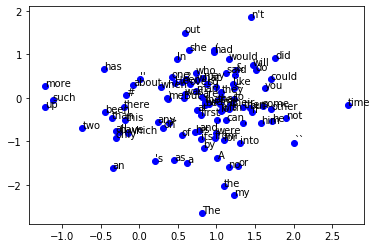

In [0]:
n = 100
x_coords = wordemb_2D[:n, 0]
y_coords = wordemb_2D[:n, 1]

plt.scatter(x_coords, y_coords, c='b')
for label, x, y in zip(vocab[:n], x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

In [0]:
from gensim.models import word2vec

sentences = word2vec.LineSentence(filepath)
model = word2vec.Word2Vec(sentences, size=50)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
model.wv.most_similar(positive='the')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('every', 0.6385283470153809),
 ('eternity', 0.6074800491333008),
 ('its', 0.5911273956298828),
 ('masonry', 0.5906268358230591),
 ('entire', 0.5666809678077698),
 ('America', 0.5587772130966187),
 ('proceeding', 0.5579907298088074),
 ('intersection', 0.5565259456634521),
 ('validity', 0.5466636419296265),
 ('free', 0.5426400303840637)]